<a href="https://colab.research.google.com/github/kaiyoyume/zerodeeplearning_2/blob/main/%EF%BC%93%E7%AB%A0%E3%80%80word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#3章　word2vec
単語の分散表現・・・単語を密な固定長ベクトルに変換したもの。

「推論ベースの手法」によって、**単語の分散表現**を得たい。  
「推論ベースの手法」は、推論する手法で、その推論にはニューラルネットワークが使える。    
推論ベースの手法のひとつに、word2vecがある。  
word2vecは、シンプルな２層のニューラルネットワークで構成されている。  
この章では、処理効率は低いが分かりすい"シンプルな"word2vecを実装する。  
大きなデータセットは扱えないが、小さなデータセットなら問題なく処理できる。

## 3.1　推論ベースの手法とニューラルネットワーク

###3.1.1 カウントベースの手法の問題点  

前章のカウントベースの手法では、学習データを一度にまとめて処理していた。  
それに対して、推論ベースの手法では、学習データの一部を使って、逐次的に学習する。  

これが意味することは、語彙数が大きいコーパスにおいてSVDなどの計算量が膨大で処理が難しい場合でも、ニューラルネットワークではデータを小分けにして学習できる。  

さらに、ニューラルネットワークの学習は複数マシン/複数GPUに利用による並列計算も可能であり、全体の学習も高速化できる。


###3.1.2 推論ベースの手法の概要
推論ベースの手法では「推論」することが主な作業になる。  
これは、図3-2で示すように、周囲の単語（コンテキスト）が与えられたときに、「？」にどのような単語が出現するのかを推測する作業である。

「**you** ? **goodbye** and I say hello.」

こののような推論問題を解くこと、そして、学習することが「推論ベースの手法」の扱う問題である。  
このような問題を繰り返し解くことで、単語の出現パターンを学習する。

推論ベースの手法では、何らかのモデルが登場する。  
私たちは、そのモデルにニューラルネットワークを使う。  
モデルはコンテキスト情報を入力として受け取り、（出現しうるであろう）各単語の出現する確率を出力する。  
そのような枠組みの中で、正しい推測ができるように、コーパスを使ってモデルの学習を行う。  
そして、その学習結果として、単語の分散表現を得られるというのが推論ベースの手法の全体図になる。  

###3.1.3 ニューラルネットワークにおける単語の処理方法
これから、ニューラルネットワークを使って「単語」を処理する。  
ニューラルネットワークは"you”や"say"などの単語を、そのままでは処理できないので、単語を「固定長のベクトル」に変換する必要がある。

そのための方法のひとつは、単語を**one-hot表現**（または**one-hotベクトル**）で変換することである。  
one-hot表現とは、ベクトルの要素の中でひとつだけが１で、残りはすべて０であるようなベクトルを言う。  

例えば、「You say goodbye and I say hello.」という1文をコーパスとして扱うと、コーパスには語彙が全部で７個存在する。（"you",　"say",　"goodbye",　"and",　"I",　"hello",　"."）  
このとき各単語は下の表のようにone-hot表現へ変換することができる。

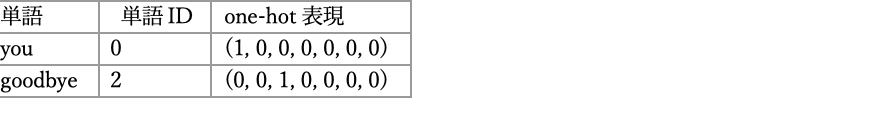

このように単語を固定長のベクトルに変換してしまえば、ニューラルネットワークの入力層はニューロンの数を"固定"することができる。

入力層は７つのニューロンによって表される。 
このとき、７つのニューロンはそれぞれ７つの単語に対応する。

このように、単語をベクトルで表すことができれば、そのベクトルはニューラルネットワークを構成する様々な「レイヤ」によって処理できるようになる。

たとえば、one-hot表現で表された単語を全結合層で変換する場合は、入力層のニューロンの重み付き和が中間層のニューロンとなる。

本章では、全結合層はバイアスを用いない。

全結合層による変換は、次のように書くことができる。

In [ ]:
##全結合による変換
import numpy as np 
c = np.array([[0, 1, 0, 0, 0, 0, 0]]) #入力
W = np.random.randn(7, 3) #重み
h = np.dot(c, W)  #中間ノード
print(h)

[[-1.00952946  0.27085363 -0.74458122]]


このコード例では、単語IDが1の単語をone-hot表現で表し、それを全結合層によって変換される例を示している。  
全結合層の計算は行列の積によって行う。（本章ではバイアスは省略）  
行列の積c*wを求めることは、重みの行ベクトルを"抜き出す"ことに相当する。

MatMulレイヤでも同じことができる。

In [ ]:
#バイアスを用いない全結合層のレイヤ
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx

MatMulレイヤに重みWを設定し、forward()メソッドによって順伝搬の処理を行う。  


In [ ]:
c = np.array([[1, 0, 0, 0, 0, 0, 0]]) 
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[1.14764922 0.41950494 1.3480938 ]]


##3.2 シンプルなword2vec
これで準備が整ったので、word2vecの実装に取りかかる。  

これから行うことは、図3-3で示される「モデル」にニューラルネットワークを組み込むことである。 

ここでは、そのニューラルネットワークに、word2vecで提案されている**continuous bag-of-words**(**CBOW**)と呼ばれるモデルを使う。


###3.2.1 CBOWモデルの推論処理

CBOWモデルは、コンテキストからターゲットを推測することを目的としたニューラルネットワークである。（「ターゲット」は中央の単語、その周囲の単語が「コンテキスト」）。  
このCBOWモデルをできるだけ正確な推論ができるように訓練することで、単語の分散表現を獲得することができる。

CBOWモデルへの入力はコンテキストである。このコンテキストは、['you', 'goodbye']のような単語のリストで表される。  
それをone-hot表現に変換することで、CBOWモデルが処理できるように調整する。

CBOWモデルの推論処理は、次のように実装できる。
推論処理とは「スコア」を求める処理を指している。

In [ ]:
#CBOWの推論処理

#サンプルのコンテキストデータ
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

#重みの初期化
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

#レイヤの生成
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

#順伝播
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5*(h0 + h1)
s = out_layer.forward(h)

print(s) #各単語のスコア（出現確率）

[[ 0.04345703  0.13464149  0.20385304  0.84949028 -0.69599807 -0.11680884
  -0.27993936]]


CBOWモデルは最初に２つのMatMulレイヤがあり、その２つの出力を加算する。  
その加算された値に0.5を乗算して平均が求められ、それが中間層のニューロンとなる。  
最後に、中間層のニューロンに対して、別のMatMulレイヤが適用されスコアが出力される。  

###3.2.2 CBOWモデルの学習
ここまで、説明したCBOWモデルは、出力層において各単語のスコアを出力した。  
このスコアに対してSoftmax関数を適用することで、「確率」を得ることができる。  
この確率は、コンテキスト（前後の単語）が与えれたときに、その中央にどの単語が出現するのかを表す。  

この確率と教師ラベルから交差エントロピー誤差を求め、それを損失として学習を行う。

###3.2.3 word2vecの重みと分散表現
これまで説明してきたように、word2vecで使用されるネットワークには２つの重みがある。  
それは、入力側の全結合層の重み($W_{in}$）と、出力側の全結合層の重み($W_{out}$)である。  
そして、入力側の重み$W_{in}$の各行が、各単語の分散表現に対応する。  
さらに、出力側の重み$W_{out}$についても、単語の意味がエンコードされたベクトルが格納されていると考えられる。  

word2vecに関して言えば、単語の分散表現は、「入力側の重みだけを利用する」というのがもっともポピュラーな選択肢である。  
それにならい、$W_{in}$を単語の分散表現として利用する。


##3.3 学習の準備

###3.3.1 コンテキストとターゲット
これからword2vecの学習を行うにあたって、まずは学習データの準備を行う。  
ここでは、簡単な例として、これまでと同じく「You say goodbye and I say hello.」という一文をコーパスとして使う。 

まずは、コーパスのテキストを単語IDに変換する。



In [ ]:
def preprocess(text):
  text = text.lower()
  text = text.replace('.', ' .')
  words = text.split(' ')

  word_to_id = {}
  id_to_word = {}
  for word in words:
    if word not in word_to_id:
      new_id = len(word_to_id)
      word_to_id[word] = new_id
      id_to_word[new_id] = word
  
  corpus = np.array([word_to_id[w] for w in words])

  return corpus, word_to_id, id_to_word

In [ ]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

[0 1 2 3 4 1 5 6]


In [ ]:
print(id_to_word)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


単語IDの配列であるcorpusから、contextsとtargetを作る関数を実装する。

In [ ]:
def create_contexts_target(corpus, window_size=1):

    # target は corpus の前後からwindow_sizeを引いたもの
    target = corpus[window_size:-window_size]
    contexts = []

    # target の前後window_size分を contexts とする       
    for idx in range(window_size, len(corpus)-window_size):  # idx = 1 〜 6
        cs = []
        for t in range(-window_size, window_size + 1):  # t = -1, 0, 1
           if t == 0:
                continue  # t = 0 のときは何もしない            
           cs.append(corpus[idx + t])  # cs = courpus[idx-1, idx+1]
        contexts.append(cs)
    return np.array(contexts), np.array(target)

In [ ]:
contexts, target = create_contexts_target(corpus,window_size=1)

In [ ]:
print(contexts)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]


In [ ]:
print(target)

[1 2 3 4 1 5]


contextsの０次元目には各コンテキストデータが格納されている。  
具体的にいうと、contexts[0]は０番目のコンテキスト、context[1]は1番目のコンテキスト・・・になる。  
同様に、ターゲットについておm、target[0]は0番目のターゲット、target[1]は1番目のターゲット・・・と格納されている。

これで、コーパスからコンテキストからターゲットを作ることができた。  
###3.3.2 one-hot表現への変換
続いてコンテキストからターゲットをone-hot表現に変換して、CBOWモデルに与えられる形にする。

In [ ]:
def convert_one_hot(corpus, vocab_size):

    N = corpus.shape[0]

    if corpus.ndim == 1:  # 1次元の場合 (target の場合)
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)  # ゼロ行列作成
        for idx, word_id in enumerate(corpus):  # targetからword_idへ順次代入
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:  # 2次元の場合 (contexts の場合)
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)  # ゼロ行列作成
        for idx_0, word_ids in enumerate(corpus):  # contextsからword_idsへ順次代入
            for idx_1, word_id in enumerate(word_ids):  # word_idsからword_idへ順次代入
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [ ]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [ ]:
print(contexts)

[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


In [ ]:
print(target)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


これで、学習データの準備が終わった。  

###3.4 CBOWモデルの実装
続いて、本題となるCBOWモデルの実装を行う。  


図3-19 CBOWモデルのネットワーク構成

図3-19のニューラルネットワークをSimpleCBOWという名前で実装する。

In [ ]:
# CBOWの実装
class SimpleCBOW:
    # 初期化メソッドの定義
    def __init__(self, vocab_size, hidden_size):  #語彙数、中間層のニューロンの数
        # ニューロン数を保存
        V = vocab_size  # 入力層と出力層
        H = hidden_size # 中間層
        
        # 重みの初期値を生成
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # レイヤを生成
        self.in_layer0 = MatMul(W_in)  # 入力層
        self.in_layer1 = MatMul(W_in)  # 入力層
        self.out_layer = MatMul(W_out) # 出力層
        self.loss_layer = SoftmaxWithLoss() # 損失層
        
        # 各レイヤをリストに格納
        layers = [
            self.in_layer0, 
            self.in_layer1, 
            self.out_layer, 
            self.loss_layer
        ]
        
        # 各レイヤのパラメータと勾配をリストに格納
        self.params = [] # パラメータ
        self.grads = []  # 勾配
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # 単語の分散表現を保存
        self.word_vecs = W_in
    
    # 順伝播メソッドの定義
    def forward(self, contexts, target):
        # 重み付き和を計算
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5                            #平均をとって中間層のニューロンを求める。
        
        # スコアを計算
        score = self.out_layer.forward(h)
        
        # 交差エントロピー誤差を計算
        loss = self.loss_layer.forward(score, target)
        return loss
    
    # 逆伝播メソッドの定義
    def backward(self, dout=1):
        # Lossレイヤの勾配を計算
        ds = self.loss_layer.backward(dout)
        
        # 出力層の勾配を計算
        da = self.out_layer.backward(ds)
        da *= 0.5
        
        # 入力層の勾配を計算
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

###3.4.1　学習コードの実装
CBOWモデルの学習は通常のニューラルネットワークの学習とまったく同じである。  
まずは学習データを準備して、ニューラルネットワークに与える。  
そして勾配を求めて、重みパラメータを逐一アップデートする。  
ここでは、その学習プロセスをTrainerクラスに行わせる。  
それでは、学習のためのソースコードを示す。

#### softmaxの実装(Softmax-with-Lossレイヤ用)

In [ ]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

#### クロスエントロピー誤差の実装(Softmax-with-Lossレイヤ用)

In [ ]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

#### Softmax-with-Lossレイヤの実装

In [ ]:
class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmaxの出力
        self.t = None  # 教師ラベル

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 教師ラベルがone-hotベクトルの場合、正解のインデックスに変換
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx


#### Trainerクラスに必要

In [ ]:
def remove_duplicate(params, grads):
    '''
    パラメータ配列中の重複する重みをひとつに集約し、
    その重みに対応する勾配を加算する
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 重みを共有する場合
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 勾配の加算
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 転置行列として重みを共有する場合（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

#### Trainerクラスに必要

In [ ]:
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

#### ニューラルネットワークの学習を行うTrainerクラス

In [ ]:
import numpy
import time
import matplotlib.pyplot as plt

class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # シャッフル
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 評価
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()

#### パラメータの更新を行うアルゴリズム

In [ ]:
class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

パラメータの更新を行う手法には、Adamを用いる。

Trainerクラスは、ニューラルネットワークの学習を行ってくれる。  
これは学習データからミニバッチを選び出し、それをニューラルネットワークに与えて勾配を求め、その勾配をOpitimizerに与えてパラメータの更新をするという一連の作業を行う。

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

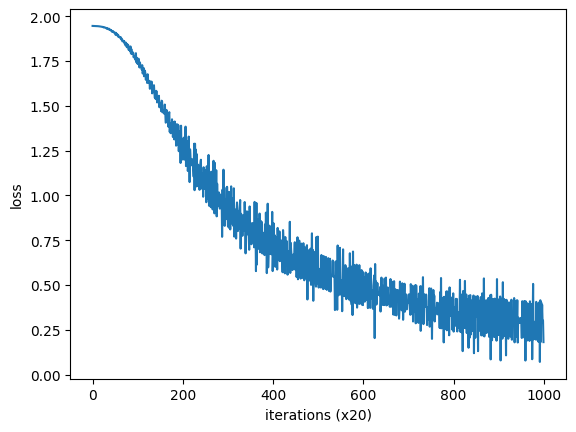

aaaa


In [ ]:
window_size = 1
hidden_size = 5 
batch_size = 3
max_epoch = 1000

#学習データの準備
text = 'You say goodbye and I say hello.'   

#学習データの前処理
corpus, word_to_id, id_to_word = preprocess(text)

#学習データのone-hot表現化
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

#学習
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

上の図は、学習の経過をグラフで表示したものである。
横軸は学習の回数、縦軸は損失を表している。  

学習回数を重ねるごとに、損失が減少していることがわかる。  
うまく学習できているようである。  

それでは、学習が終わった後の重みパラメータを見ていきたい。  
ここでは、入力側のMatMulレイヤの重みを取り出し、実際に中身を確認してみることにする。  
なお、入力側のMatMulレイヤの重みはメンバ変数のword_vecsに設定されている。


In [ ]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-0.85849947 -0.92845005  0.899041   -0.9200242  -1.7018394 ]
say [ 1.1433655  0.8794653 -1.170082   1.1800435 -1.2999091]
goodbye [-1.0805677  -1.020402    0.99637717 -0.99217117  0.04992517]
and [ 0.67271984  1.8690711  -0.1597391   0.6694496  -1.5470127 ]
i [-1.055842   -1.0267671   1.0070229  -0.9825193   0.05926484]
hello [-0.88861626 -0.9288655   0.9045676  -0.89443624 -1.7150296 ]
. [ 1.3193552 -0.9588528 -1.6636506  1.3852448 -0.243235 ]


word_vecsという名前で重みを取り出すと、各行に対応する単語IDの分散表現が格納されている。  




これで、単語を密なベクトルで表すことができた。  
これが単語の分散表現である。  
この分散表現は、「単語の意味」をうまく捉えたベクトル表現になっていることが期待できる。  

しかし残念ながら、ここで扱ったコーパスは、あまりにもサイズが小さいので良い結果が得られない。  
実際、コーパスを大きく実用的なものに変換すれば、良い結果が得られるだろう。  

しかし、その場合は処理速度の点で問題が発生する。  
というのも、現段階でのCBOWモデルの実装は処理効率の点でいくつか課題を抱えている。  

次章では現状の"シンプル"なCBOWモデルに対して改良を加え、"本物"のCBOWモデルを実装する。